**Thinking1：如果你是某P2P租车的技术负责人，你会如何设计个性化推荐和搜索排序**

1. car embedding:
  - 使用近期的用户浏览数据进行车辆的embedding
    - 点击的车、跳过的车、长时间停留的车、收藏的车、咨询的车、被车主拒绝的车、预定的车、最后一次长时间停留的车
    - 用word2vec方法对上述数据进行训练，得到每辆车的embedding向量
  - 用户类型车类型的type embedding
    - 先按静态特征对用户和车进行分类
      - 车辆：品牌、车型、颜色、行驶里程数、出厂日期等
      - 用户：年龄、职业、地域、性别等
    - 使用长期的预定数据进行训练，得到不同类型的embedding
2. search ranking:
  - 建模：
    - 对以往的搜索数据（近一段时间），根据用户点击行为对每一条搜索内容进行打分，得到训练的label
    - 构建每一辆车的特征（用户、车辆的静态特征+交叉特征+各种embedding特征）
    - 用GBDT算法训练得到模型
  - 对新的搜索请求得到符合搜索条件的车辆的分数，进行排序
3. 个性化推荐
  - 冷启动：新用户可根据静态特征得到用户类别，推荐同类别用户中排名比较高的车辆
  - 首页推荐：根据用户历史浏览数据，用embedding特征得到相似度较高的进行推荐
  - 实时推荐：在用户点击过程中，进行实时embedding特征计算进行推荐

**Action1: 信用卡违约率检测**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [2]:
# 读入数据
data = pd.read_csv('./UCI_Credit_Card.csv')

In [11]:
# 获取训练数据
X = data.drop(['ID', 'default.payment.next.month'], axis=1).values
y = data['default.payment.next.month'].values

In [13]:
# 训练测试集切分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [14]:
# 模型
classifiers = [
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier()
]
# 模型名字
classifier_names = [
    'svc',
    'decisiontreeclassifier',
    'randomforestclassifier',
    'kneighborsclassifier'
]
# 参数范围
classifier_param_grid = [
    {'svc__C':[1], 'svc__gamma':[0.01, 0.05, 0.1]}, #best=0.05
#     {'decisiontreeclassifier__max_depth':[6,9,11]}, # best=6
    {'decisiontreeclassifier__max_depth':[2,4,6]}, # best=4
#     {'randomforestclassifier__n_estimators':[3,5,6]},# best=6
    {'randomforestclassifier__n_estimators':[6,7,8]},#best=8
#     {'kneighborsclassifier__n_neighbors':[4,6,8]}, #best 8
    {'kneighborsclassifier__n_neighbors':[8, 10, 12]},#best 12
]

In [65]:
# 用GridSearch寻找最优参数
def GridSearchCV_work(pipeline, X_train, y_train, X_test, y_test, model_param_grid , score = 'accuracy'):
    grid_search = GridSearchCV( estimator=pipeline, param_grid=model_param_grid, scoring=score)
    # 最优参数
    search = grid_search.fit(X_train, y_train)
    print('GridSearchCV best parameters:', search.best_params_)
    print('GridSearchCV best score:', search.best_score_)
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    print(f'accuracy{accuracy:.4f}')
    
    response = {}
    response['y_pred'] = y_pred
    response['accuracy'] = accuracy
    return response

In [36]:
# 遍历所有模型找到最优模型和最优参数
for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            (model_name, model)
    ])
    result = GridSearchCV_work(pipeline, X_train, y_train, X_test, y_test, model_param_grid , score = 'accuracy')


GridSearchCV best parameters: {'svc__C': 1, 'svc__gamma': 0.05}
GridSearchCV best score: 0.8181428571428573
accuracy0.8216
GridSearchCV best parameters: {'decisiontreeclassifier__max_depth': 4}
GridSearchCV best score: 0.8186666666666665
accuracy0.8209
GridSearchCV best parameters: {'randomforestclassifier__n_estimators': 8}
GridSearchCV best score: 0.8002380952380952
accuracy0.7983
GridSearchCV best parameters: {'kneighborsclassifier__n_neighbors': 12}
GridSearchCV best score: 0.8062380952380952
accuracy0.8082


**上述模型中，SVM(C=1, gamma=0.05)表现最好**

**Action2：信用卡欺诈分析**

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix, classification_report

In [2]:
# 读取数据
path = './L12/credit_fraud/creditcard.csv'
data = pd.read_csv(path)

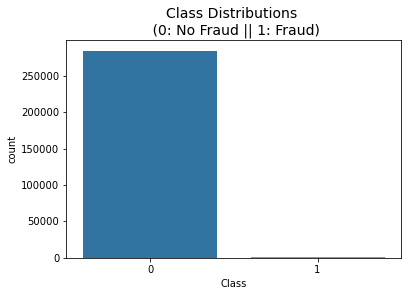

No Frauds: 99.83% of the dataset
Frauds: 0.17% of the dataset


In [3]:
# 数据探索：正负样本非常不平衡
sns.countplot(x='Class', data=data)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()
print(f'No Frauds: {round(data["Class"].value_counts()[0]/len(data) * 100,2)}% of the dataset')
print(f'Frauds: {round(data["Class"].value_counts()[1]/len(data) * 100,2)}% of the dataset')

In [10]:
# 数据归一化, 由于其他features已经做了归一化
scaler = MinMaxScaler()
data['Amount'] = scaler.fit_transform(data[['Amount']].values)
X = data.drop(['Class', 'Time'], axis=1).values
y = data['Class'].values
# 由于正负样本极度不平衡，需要保持Train/Test中的正负样本比例
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2021)
train_index, test_index = list(sss.split(X, y))[0]
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]
# Train/Test正负样本分布
print(f'Label Distributions: \n\
Train({y_train.sum()/ len(y_train)*100:.4f}%Fraud)\n\
Test({y_test.sum()/ len(y_test)*100:.04f}%Fraud)')

Label Distributions: 
Train(0.1729%Fraud)
Test(0.1720%Fraud)


In [38]:
# 使用LR模型进行拟合
# 5 fold交叉验证, 这里保持各类别的比重
sss = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
# 存储五个模型
models = []
for train, test in sss.split(X_train, y_train):
    model = LogisticRegression(solver='liblinear') 
    model.fit(X_train[train], y_train[train])
    models.append(model)

In [42]:
'''进行预测'''
def predict(models):
    # 存储概率值
    y_probs = []
    for model in models:
        y_prob = model.predict_proba(X_test)
        # 只取类别1也就是Fraud的概率
        y_probs.append(y_prob[:,1])
    # 五个模型做平均
    y_prob = np.array(y_probs).mean(axis=0)
    # 预测值
    y_pred = np.zeros(len(X_test))
    y_pred[y_prob>0.5] = 1
    
    return y_prob, y_pred

y_prob, y_pred = predict(models)

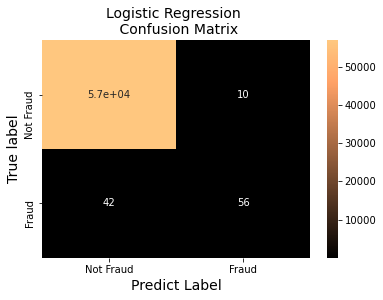

In [43]:
'''混淆矩阵'''
def plot_confusion_matrix(y_test, y_pred):
    cf = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf, annot=True, cmap=plt.cm.copper)
    plt.title("Logistic Regression \n Confusion Matrix", fontsize=14)
    plt.xticks(ticks=[0.5, 1.5], labels=['Not Fraud', 'Fraud'], fontsize=10, rotation=0)
    plt.xlabel('Predict Label', fontsize=14)
    plt.yticks(ticks=[0.5, 1.5], labels=['Not Fraud', 'Fraud'], fontsize=10, rotation=90)
    plt.ylabel('True label', fontsize=14)
    plt.show()

plot_confusion_matrix(y_test, y_pred)

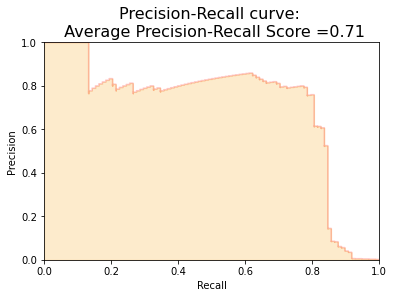

In [57]:
'''准确率-召回率曲线'''
def plot_precision_recall(y_test, y_prob):
    average_precision = average_precision_score(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)

    plt.step(recall, precision, color='r', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='#F59B00')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall curve: \n Average Precision-Recall Score ={average_precision:.2f}', fontsize=16)
    plt.show()
    
plot_precision_recall(y_test, y_prob)

In [47]:
# 分类器性能报告
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.57      0.68        98

    accuracy                           1.00     56962
   macro avg       0.92      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962



**可以看到这里的class=1的recall(TPR)比较低，也就是欺诈的检出率比较低**  
注意到欺诈样本所占比重很低，所以模型比较难检出欺诈也是比较合理的。  
后面我们用SMOTE算法对欺诈样本进行过采样，增加欺诈样本的比重。

In [60]:
# 用SMOTE算法对少数样本进行过采样，使得两个类别权重相等
sampler = SMOTE(sampling_strategy='minority', random_state=20)
# 5 fold交叉验证
sss = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
# 存储五个模型
models_sm = []
for train, test in sss.split(X_train, y_train):
    X_sm, y_sm = sampler.fit_sample(X_train[train], y_train[train])
    model_sm = LogisticRegression(solver='liblinear')
    model_sm.fit(X_sm,y_sm)
    models_sm.append(model_sm)

In [61]:
'''进行预测'''
y_prob_sm, y_pred_sm = predict(models_sm)

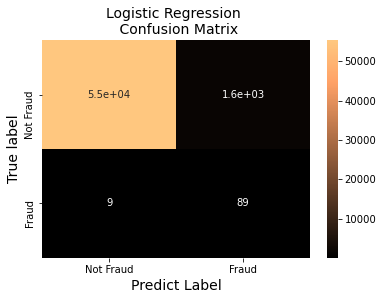

In [62]:
'''混淆矩阵'''
plot_confusion_matrix(y_test, y_pred_sm)

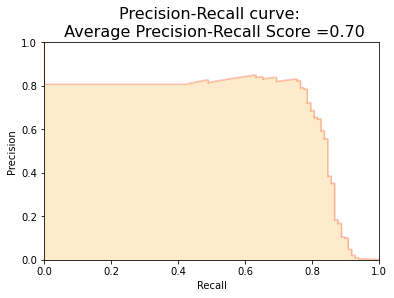

In [63]:
'''准确率-召回率曲线'''
plot_precision_recall(y_test, y_prob_sm)

In [64]:
# 分类器性能报告
print(classification_report(y_test, y_pred_sm))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.91      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962



**1. 可以看到这里recall=0.91已经很高了，说明欺诈的检出率提高了很多，由于我们把欺诈样本的比重提高了**  
2. 与此同时precision=0.05变低了很多，说明把许多不是欺诈的事件当成了欺诈。  
3. 其实这里就是一个**权衡**，可以通过改变欺诈样本采样的比例来调节。（这里把欺诈样本比例过采样到0.5，可能有点过高了）  
4. 就信用卡欺诈来说，我们希望不放过任何一笔欺诈交易，但precision过低会引起用户满意度下降。  